# 1. 模型原理

Yoon Kim在论文(2014 EMNLP) Convolutional Neural Networks for Sentence Classification提出TextCNN。将卷积神经网络CNN应用到文本分类任务，利用多个不同size的kernel来提取句子中的关键信息（类似于多窗口大小的n-gram），从而能够更好地捕捉局部相关性。与传统图像的CNN网络相比, textCNN 在网络结构上没有任何变化(甚至更加简单了), 从图一可以看出textCNN 其实只有一层卷积,一层max-pooling, 最后将输出外接softmax 来n分类。

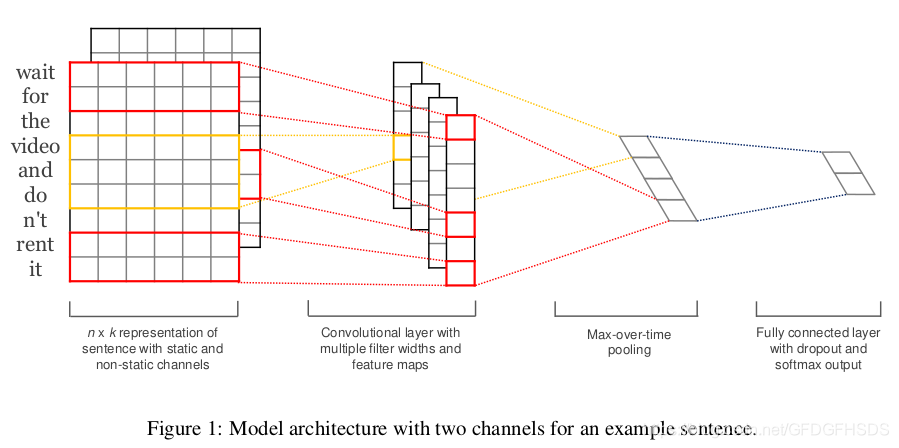

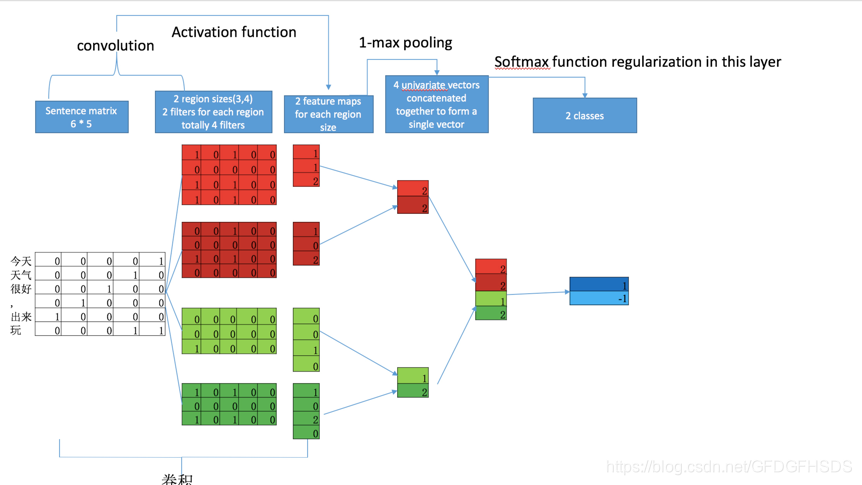

# 2. 代码实现

In [4]:
# code by Tae Hwan Jung @graykode
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class TextCNN(nn.Module):
    def __init__(self):
        super(TextCNN, self).__init__()
        self.num_filters_total = num_filters * len(filter_sizes)
        self.W = nn.Embedding(vocab_size, embedding_size)
        self.Weight = nn.Linear(self.num_filters_total, num_classes, bias=False)
        self.Bias = nn.Parameter(torch.ones([num_classes]))
        self.filter_list = nn.ModuleList([nn.Conv2d(1, num_filters, (size, embedding_size)) for size in filter_sizes])

    def forward(self, X):
        embedded_chars = self.W(X) # [batch_size, sequence_length, sequence_length]
        embedded_chars = embedded_chars.unsqueeze(1) # add channel(=1) [batch, channel(=1), sequence_length, embedding_size]

        pooled_outputs = []
        for i, conv in enumerate(self.filter_list):
            # conv : [input_channel(=1), output_channel(=3), (filter_height, filter_width), bias_option]
            h = F.relu(conv(embedded_chars))
            # mp : ((filter_height, filter_width))
            mp = nn.MaxPool2d((sequence_length - filter_sizes[i] + 1, 1))
            # pooled : [batch_size(=6), output_height(=1), output_width(=1), output_channel(=3)]
            pooled = mp(h).permute(0, 3, 2, 1)
            pooled_outputs.append(pooled)

        h_pool = torch.cat(pooled_outputs, len(filter_sizes)) # [batch_size(=6), output_height(=1), output_width(=1), output_channel(=3) * 3]
        h_pool_flat = torch.reshape(h_pool, [-1, self.num_filters_total]) # [batch_size(=6), output_height * output_width * (output_channel * 3)]
        model = self.Weight(h_pool_flat) + self.Bias # [batch_size, num_classes]
        return model

if __name__ == '__main__':
    embedding_size = 2 # embedding size
    sequence_length = 3 # sequence length
    num_classes = 2 # number of classes
    filter_sizes = [2, 2, 2] # n-gram windows
    num_filters = 3 # number of filters

    # 3 words sentences (=sequence_length is 3)
    sentences = ["i love you", "he loves me", "she likes baseball", "i hate you", "sorry for that", "this is awful"]
    labels = [1, 1, 1, 0, 0, 0]  # 1 is good, 0 is not good.

    word_list = " ".join(sentences).split()
    word_list = list(set(word_list))
    word_dict = {w: i for i, w in enumerate(word_list)}
    vocab_size = len(word_dict)

    model = TextCNN()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    inputs = torch.LongTensor([np.asarray([word_dict[n] for n in sen.split()]) for sen in sentences])
    targets = torch.LongTensor([out for out in labels]) # To using Torch Softmax Loss function

    # Training
    for epoch in range(5000):
        optimizer.zero_grad()
        output = model(inputs)

        # output : [batch_size, num_classes], target_batch : [batch_size] (LongTensor, not one-hot)
        loss = criterion(output, targets)
        if (epoch + 1) % 1000 == 0:
            print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

        loss.backward()
        optimizer.step()

    # Test
    test_text = 'sorry hate you'
    tests = [np.asarray([word_dict[n] for n in test_text.split()])]
    test_batch = torch.LongTensor(tests)

    # Predict
    predict = model(test_batch).data.max(1, keepdim=True)[1]
    if predict[0][0] == 0:
        print(test_text,"is Bad Mean...")
    else:
        print(test_text,"is Good Mean!!")

Epoch: 1000 cost = 0.002647
Epoch: 2000 cost = 0.000395
Epoch: 3000 cost = 0.000127
Epoch: 4000 cost = 0.000053
Epoch: 5000 cost = 0.000025
sorry hate you is Bad Mean...


In [5]:
768/12

64.0